In [21]:
#Importing the main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [22]:
#Preventing any unnecessary verbose from popping up
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [23]:
!ls

Cleaned_tweets.csv  glove.6B.300d.txt  sample_data


In [24]:
#loading the dataset, from the json file stored in the given directory below, and visualising it
data = pd.read_csv("Cleaned_tweets.csv")
data.head(20)

,Unnamed: 0,Key Word,Username,User_ID,Datetime,Favorite_count,Geo,Coordinates,Label,Text
0,1515,ass,gametheoryosmer,1.330000e+18,11-11-2020 06:55,0,NaN,NaN,1,"my lieutenant called me a ""Pussy"" for not wipi..."
1,1167,bastard,oyibutter,1.330000e+18,11-11-2020 07:25,0,NaN,NaN,0,My fwb showed me pepper. I caught bastard feel...
2,115,Bad Fuck,Bigafterglow,1.330000e+18,11-11-2020 07:09,0,NaN,NaN,0,Oh fuck! What a bad tweet.
3,1740,bitch,ItsBillcosby,1.330000e+18,11-11-2020 07:27,0,NaN,NaN,1,If the dick fit suck it bitch 〽️™️
4,983,ass,SlayerOfWaifu,1.330000e+18,11-11-2020 06:55,1,NaN,NaN,0,If you think Fairy Tail is ass you do you 🤷🏽‍♂...
5,1520,ass,Rhodocrosite2,1.330000e+18,11-11-2020 06:55,0,NaN,NaN,1,her ass; a canvas
6,546,cunt,M_Loos,1.330000e+18,11-11-2020 09:44,0,NaN,NaN,0,Piers Morgan wants people who refuse to take t...
7,434,boobs,ajaxpenumbrabot,1.330000e+18,11-11-2020 08:00,0,NaN,NaN,0,"Hammetts on her hair, I had either-but boobs i..."
8,1259,bitch,MondeBlvck,1.330000e+18,11-11-2020 07:26,0,NaN,NaN,0,Bitch im cow!! i don't say moew🐮🗣️
9,1586,asslick,AlbertCarey8,1.330000e+18,08-11-2020 19:25,1,NaN,NaN,1,Just go away you asslick.


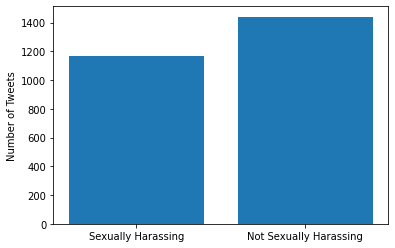

In [25]:
#Visualization
sh=0
for i in range(len(data["Label"])):
    if data["Label"].iloc[i]==1:
        sh+=1
normal=len(data["Label"])-sh
label_values={"Sexually Harassing" : sh, "Not Sexually Harassing" : normal}
plt.bar(label_values.keys(),label_values.values(),align="center")
plt.ylabel("Number of Tweets")
plt.show()

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


num_words=20000
max_sentence_len=300
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(data["Text"]))
X=tokenizer.texts_to_sequences(list(data["Text"]))
X=pad_sequences(X,maxlen=max_sentence_len)
Y=to_categorical(data["Label"].values)
print("The number of unique words in the text corpus dictionary : {}".format(len(tokenizer.word_index)))
print("The shape of the trainable data : {}".format(X.shape))
print("The shape of the labels for the data is : {}".format(Y.shape))

The number of unique words in the text corpus dictionary : 7163
The shape of the trainable data : (2612, 300)
The shape of the labels for the data is : (2612, 2)


In [27]:
embedding_words={}
file=open("glove.6B.300d.txt")
for line in file:
    #There are a number of lines containing embeddings for each word
    info=line.split(" ")
    #The first value in each line of the file is a unique word
    word=info[0]
    #The rest are embedding values of a specific dimension (to be displayed)
    embedding_values=np.array(info[1:],dtype="float32")
    #Storing these values
    embedding_words[word]=embedding_values
file.close()
print("The dimension/length of the embedding vector for each word is : {}"
     .format(len(embedding_words["go"])))

The dimension/length of the embedding vector for each word is : 300


In [59]:
from keras.layers import Embedding
from keras.initializers import Constant

#The length/dimension of the embedding vector was found to be 300 after running the previous cell
embedding_dim=len(embedding_words["go"]) #or simply 300
#Initialising the embedding matrix
embedding_matrix=np.zeros((num_words,embedding_dim))
#Forming the embedding matrix by using the embedding vectors for only those words in the text corpus of the data  
for word,i in tokenizer.word_index.items():
    if i>num_words:
        continue
    embedding_vector=embedding_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [85]:
#Creating the embedding layer further with the help of keras
#These embeddings are made non-trainable as they are pre trained to highly optimized values
embeddings=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sentence_len,trainable=False)
#Getting the shape of the embedding matrix (should be (num_words,embedding_dim)=(20000,300))
print("The shape of the embedding matrix is {}".format(embedding_matrix.shape))

The shape of the embedding matrix is (20000, 300)


In [86]:
#Building the model
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D 

model=Sequential()
model.add(embeddings)
model.add(Conv1D(32,3,activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Flatten())
model.add(Dense(30,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics="accuracy")

In [87]:
#Splittting the data into training and testing sets before fitting the model
#Using a 80% - 20% split for the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [88]:
batch_size=128 #Using a batch size of 128, during gradient descent
num_epochs=10 #Number of iterations/epochs over the training set

history=model.fit(x_train,y_train,batch_size=batch_size,epochs=num_epochs,validation_data=(x_test,y_test))


Epoch 1/10
17/17 [==============================] - 4s 85ms/step - loss: 0.6910 - accuracy: 0.5454 - val_loss: 0.6630 - val_accuracy: 0.5641
Epoch 2/10
17/17 [==============================] - 1s 41ms/step - loss: 0.6789 - accuracy: 0.5610 - val_loss: 0.6430 - val_accuracy: 0.7036
Epoch 3/10
17/17 [==============================] - 1s 42ms/step - loss: 0.6439 - accuracy: 0.6148 - val_loss: 0.6265 - val_accuracy: 0.7055
Epoch 4/10
17/17 [==============================] - 1s 42ms/step - loss: 0.6237 - accuracy: 0.6583 - val_loss: 0.5790 - val_accuracy: 0.7075
Epoch 5/10
17/17 [==============================] - 1s 41ms/step - loss: 0.5794 - accuracy: 0.6921 - val_loss: 0.5856 - val_accuracy: 0.7113
Epoch 6/10
17/17 [==============================] - 1s 41ms/step - loss: 0.5429 - accuracy: 0.7418 - val_loss: 0.5767 - val_accuracy: 0.6673
Epoch 7/10
17/17 [==============================] - 1s 42ms/step - loss: 0.5039 - accuracy: 0.7511 - val_loss: 0.5950 - val_accuracy: 0.6826
Epoch 8/10
17

In [89]:
test_performance=model.evaluate(x_test,y_test)
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))



17/17 [==============================] - 0s 14ms/step - loss: 0.6295 - accuracy: 0.6922
The loss of the model on the test set : 0.6294759511947632
The accuracy of the model on the test set : 69.21606063842773%


In [90]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 300)          6000000   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 298, 32)           28832     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 149, 32)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 149, 32)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 149, 256)          164864    
_________________________________________________________________
flatten_11 (Flatten)         (None, 38144)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 30)              

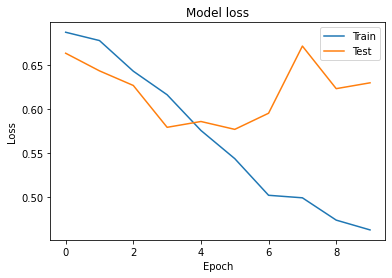

In [91]:
#Visualising the loss of the model, throughout the training process
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("modelloss_sarcasmdetection.jpg")

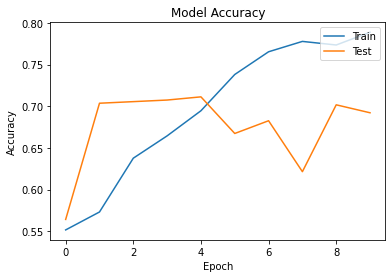

In [92]:
#Visualising the loss of the model, throughout the training process
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("modelaccuracy_sarcasmdetection.jpg")